In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall
import uuid

In [2]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

In [3]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\c9f3f2df-e3f2-11ee-8669-fcb3bcae6c16.jpg'

In [4]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    # Collect negatives
    if cv2.waitKey(1) & 0XFF == ord('n'):
        # Create the unique file path 
        imgname = os.path.join(NEG_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out negative image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [5]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
C:\Users\kaust\AppData\Local\Temp\ipykernel_32520\129719944.py:1: SyntaxWarning: invalid escape sequence '\*'
  anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
C:\Users\kaust\AppData\Local\Temp\ipykernel_32520\129719944.py:2: SyntaxWarning: invalid escape sequence '\*'
  positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
C:\Users\kaust\AppData\Local\Temp\ipykernel_32520\129719944.py:3: SyntaxWarning: invalid escape sequence '\*'
  negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)


In [6]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [7]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [8]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [9]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [10]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [11]:
embedding = make_embedding()

embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        #return tf.math.abs(input_embedding - validation_embedding)
        temp = []
        for inp_tensor, val_tensor in zip(input_embedding, validation_embedding):
            # Perform element-wise subtraction
            sub_result = inp_tensor - val_tensor
            # Append the result to the output list
            temp.append(sub_result)
        return temp

In [13]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances[0])

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [14]:
siamese_model = make_siamese_model()

siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [16]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [17]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

In [ ]:
EPOCHS = 50

train(train_data, EPOCHS)

In [19]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])

# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


[1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0]

In [20]:
y_hat

array([[1.0000000e+00],
       [3.2212263e-14],
       [1.0000000e+00],
       [9.7931249e-16],
       [6.0235927e-17],
       [8.8085440e-19],
       [1.0000000e+00],
       [5.4410655e-20],
       [1.3987921e-16],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [4.0823284e-08],
       [1.0000000e+00],
       [9.9997228e-01],
       [1.0280073e-15]], dtype=float32)

In [21]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    print(test_input)
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat) 

print(r.result().numpy(), p.result().numpy())

[[[[0.60294116 0.6186274  0.55196077]
   [0.60882354 0.622549   0.5588235 ]
   [0.60857844 0.6164216  0.5644608 ]
   ...
   [0.61960787 0.6392157  0.56078434]
   [0.6186274  0.6382353  0.5539216 ]
   [0.62352943 0.6431373  0.5568628 ]]

  [[0.60784316 0.61960787 0.5470588 ]
   [0.60784316 0.6186274  0.55490196]
   [0.6068627  0.61470586 0.5605392 ]
   ...
   [0.6284314  0.6401961  0.5735294 ]
   [0.6313726  0.6431373  0.57058823]
   [0.6313726  0.6431373  0.57058823]]

  [[0.60784316 0.6164216  0.560049  ]
   [0.6107843  0.6186274  0.56666666]
   [0.6129902  0.62083334 0.5740196 ]
   ...
   [0.6335784  0.6387255  0.5830882 ]
   [0.6313726  0.6372549  0.57941175]
   [0.6343137  0.6401961  0.5764706 ]]

  ...

  [[0.17916666 0.17720588 0.21740197]
   [0.18210784 0.18014705 0.22818628]
   [0.16764706 0.16568628 0.21446079]
   ...
   [0.10269608 0.10882353 0.10784314]
   [0.09901961 0.10588235 0.10490196]
   [0.09803922 0.09901961 0.10098039]]

  [[0.19338235 0.18553922 0.23455882]
   [0.1

In [22]:
yhat

array([[1.0472173e-12],
       [3.8673561e-12],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

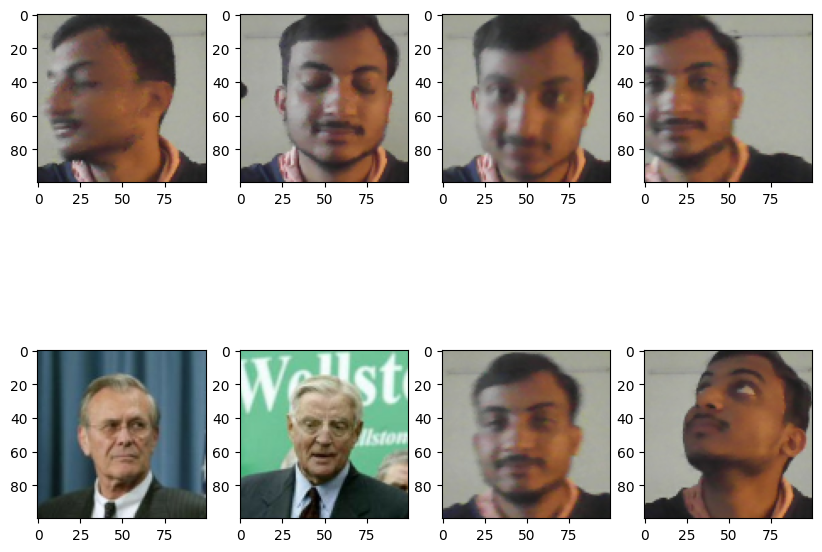

In [23]:
# Set plot size 
plt.figure(figsize=(10,8))

plt.subplot(2,4,1)
plt.imshow(test_input[0])
plt.subplot(2,4,2)
plt.imshow(test_input[1])
plt.subplot(2,4,3)
plt.imshow(test_input[2])
plt.subplot(2,4,4)
plt.imshow(test_input[3])

plt.subplot(2,4,5)
plt.imshow(test_val[0])
plt.subplot(2,4,6)
plt.imshow(test_val[1])
plt.subplot(2,4,7)
plt.imshow(test_val[2])
plt.subplot(2,4,8)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

In [24]:
siamese_model.save('siamesemodelv2.keras')

siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.keras', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [25]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

siamese_model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application', 'verification_image')):
        input_img = preprocess(os.path.join('application', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application', 'verification_image', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application', 'verification_image'))) 
    verified = verification > verification_threshold
    
    return results, verified

# def verify(model, detection_threshold, verification_threshold):
#     results = []
    
#     detection = 0
#     input_temp = preprocess(os.path.join('application', 'input_image', 'input_image.jpg'))
#     for image in os.listdir(os.path.join('application', 'verification_image')):
        
#         validation_img=preprocess(os.path.join('application', 'verification_image', image))
        
#         result = model.predict(list(np.expand_dims([input_temp, validation_img], axis=1)))
#         results.append(result)

    

#     detection = np.sum(np.array(results) > detection_threshold)

#     verification = detection / len(os.listdir(os.path.join('application', 'verification_image'))) 
#     verified = verification > verification_threshold
    
#     return results, verified

# def verify(model, detection_threshold, verification_threshold):
#     results = []

#     VER_PATH = os.path.join('application', 'verification_image')
#     INP_PATH = os.path.join('application', 'input_image')

#     verification_image = tf.data.Dataset.list_files(VER_PATH+'\*.jpg').take(100)
#     input_image = tf.data.Dataset.list_files(INP_PATH+'\*.jpg').take(100)

#     check = tf.data.Dataset.zip((input_image, verification_image, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))

#     check = check.map(preprocess_twin)

#     # input_temp = preprocess(os.path.join('application', 'input_image', 'input_image.jpg'))

#     # input_img = input_img.batch(16)
#     # input_img = input_img.prefetch(8)

#     # validation_img = validation_img.batch(16)
#     # validation_img = validation_img.prefetch(8)

#     # for input_i, validation_i, y_i in test_data.as_numpy_iterator():
#     #     results.append(siamese_model.predict([input_i, validation_i]))

#     for i in preprocess(input_image).as_numpy_iterator():
#         for j in preprocess(verification_image).as_numpy_iterator():
#             results.append(siamese_model.predict([i,j]))

#     detection = np.sum(np.array(results) > detection_threshold)

#     verification = detection / len(os.listdir(os.path.join('application', 'verification_image'))) 
#     verified = verification > verification_threshold
    
#     return results, verified

In [28]:
# cap=cv2.VideoCapture(0)

# while cap.isOpened():
#     ret,frame = cap.read()
#     frame = frame[120:120+250,200:200+250, :]

#     cv2.imshow('verification',frame)
#     if cv2.waitKey(10) & 0xFF == ord('v'):
#         for i in range(1,100):
#             cv2.imwrite(os.path.join('application','input_image','{}.jpg'.format(uuid.uuid1())),frame)
        
#         results, verification = verify(siamese_model,0.9,0.7)
#         print(results)
#         print(verification)

#     if cv2.waitKey(10) & 0xFF == ord('x'):
#         results, verification = verify(siamese_model,0.9,0.7)
#         print(results)
#         print(verification)
        
#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

cap=cv2.VideoCapture(0)

while cap.isOpened():
    ret,frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    cv2.imshow('verification',frame)
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application','input_image','input_image.jpg'),frame)
        results, verification = verify(siamese_model,0.7,0.7)
        print(np.squeeze(results))
        print(verification)

    if cv2.waitKey(10) & 0xFF == ord('x'):
        results, verification = verify(siamese_model,0.7,0.7)
        print(np.squeeze(results))
        print(verification)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━